In [ ]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

In [1]:
import sys ; sys.path.append('../')
import torch.optim as optim
import torch
import seaborn as sb
import pytorch_lightning as pl
import numpy as np

from sklearn.model_selection import train_test_split
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import RevDuffing
from learn_KKL.learner import Learner

sb.set_style('whitegrid')

In [2]:
# Set up the system
system = RevDuffing()

In [3]:
# Instantiate the observer
observer = LuenbergerObserver(dim_x=2, dim_y=1, method='Supervised')
observer.set_dynamics(system)
# Generate (x_i, z_i) data by running system backward, then system + observer
# forward in time
data = observer.generate_data_svl(np.array([[-1, 1.], [-1., 1.]]), 10000)
print(data.shape)
data, val_data = train_test_split(data, test_size=0.3, shuffle=True)

# Train the forward transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 15}
optimizer_options = {'weight_decay': 1e-6}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T = Learner(observer=observer, system=system, training_data=data,
                    validation_data=val_data, method='T', batch_size=10,
                    lr=1e-3, optimizer=optim.Adam,
                    optimizer_options=optimizer_options,
                    scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                    scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


torch.Size([10000, 5])
Results saved in in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2


In [4]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T)
learner_T.save_results(limits=np.array([[-1, 1.], [-1., 1.], [-1., 1.]]),
                       nb_trajs=10, tsim=(0, 60), dt=1e-2,
                       checkpoint_path=checkpoint_callback.best_model_path)


  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2/tb_logs


Validation sanity check: 0it [00:00, ?it/s]

/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in t

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch     7: reducing learning rate of group 0 to 1.0000e-04.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Saved model in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T/exp_2


0

In [5]:
# Train the inverse transformation using pytorch-lightning and the learner class
# Options for training
trainer_options={'max_epochs': 20}
optimizer_options = {'weight_decay': 1e-8}
scheduler_options = {'mode': 'min', 'factor': 0.1, 'patience': 3,
                     'threshold': 1e-4, 'verbose': True}
stopper = pl.callbacks.early_stopping.EarlyStopping(
    monitor='val_loss', min_delta=5e-4, patience=3, verbose=False, mode='min')
# Instantiate learner
learner_T_star = Learner(observer=observer, system=system, training_data=data,
                         validation_data=val_data, method='T_star',
                         batch_size=10, lr=5e-4, optimizer=optim.Adam,
                         optimizer_options=optimizer_options,
                         scheduler=optim.lr_scheduler.ReduceLROnPlateau,
                         scheduler_options=scheduler_options)
# Define logger and checkpointing
logger = TensorBoardLogger(save_dir=learner_T_star.results_folder + '/tb_logs')
checkpoint_callback = ModelCheckpoint(monitor='val_loss')
trainer = pl.Trainer(
    callbacks=[stopper, checkpoint_callback], **trainer_options, logger=logger,
    log_every_n_steps=1, check_val_every_n_epoch=3)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Results saved in in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0


In [6]:
# To see logger in tensorboard, copy the following output name_of_folder
print(f'Logs stored in {learner_T_star.results_folder}/tb_logs')
# which should be similar to jupyter_notebooks/runs/method/exp_0/tb_logs/
# Then type this in terminal:
# tensorboard --logdir=name_of_folder --port=8080

# Train and save results
trainer.fit(learner_T_star)
learner_T_star.save_results(limits=np.array([[-1, 1.], [-1., 1.]]),
                            nb_trajs=10, tsim=(0, 60), dt=1e-2,
                            checkpoint_path=checkpoint_callback.best_model_path)


  | Name  | Type               | Params
---------------------------------------------
0 | model | LuenbergerObserver | 26.1 K
---------------------------------------------
26.1 K    Trainable params
0         Non-trainable params
26.1 K    Total params
0.104     Total estimated model params size (MB)


Logs stored in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0/tb_logs


Validation sanity check: 0it [00:00, ?it/s]

/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:372: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/mona/PhD_code/learn_observe_KKL/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in t

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch    12: reducing learning rate of group 0 to 5.0000e-05.


Validating: 0it [00:00, ?it/s]

Epoch    16: reducing learning rate of group 0 to 5.0000e-06.


Validating: 0it [00:00, ?it/s]

Saved model in /Users/mona/PhD_code/learn_observe_KKL/src/jupyter_notebooks/runs/RevDuffing/Supervised/T_star/exp_0


No handles with labels found to put in legend.


Shape of mesh for evaluation: torch.Size([10000, 5])


No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [21]:
# Compute new metrics from loaded model
import dill as pkl
import pandas as pd
import os
import matplotlib.pyplot as plt
from learn_KKL.utils import RMSE, generate_mesh
# model = pkl.load(open('runs/RevDuffing/Autoencoder/exp_0/model.pkl', 'rb'))
# learner_T_star = pkl.load(open('runs/RevDuffing/Supervised/Base_case/N=10000'
#                                '/wc=1/exp_1/learner.pkl', 'rb'))

Shape of mesh for evaluation: torch.Size([10000, 5])


No handles with labels found to put in legend.


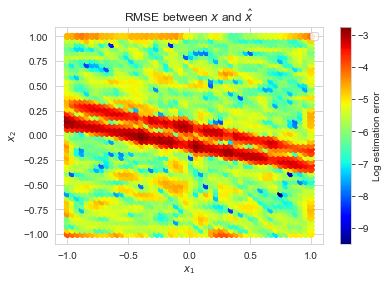

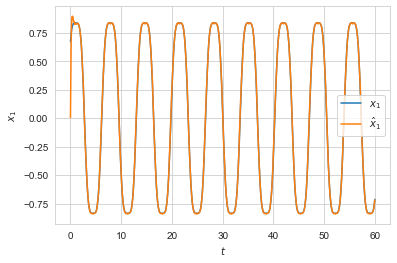

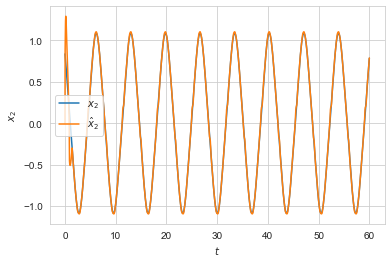

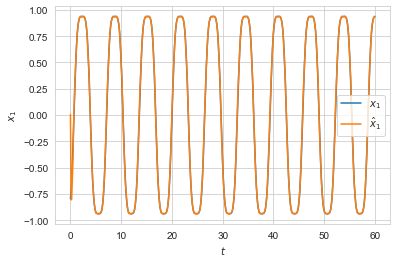

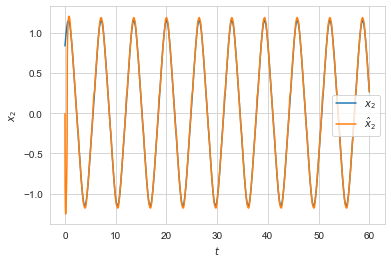

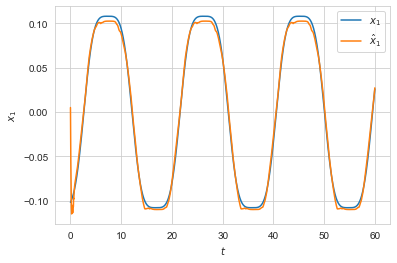

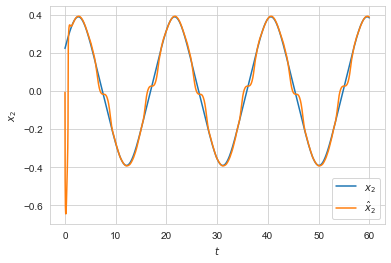

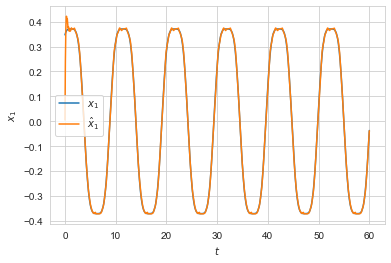

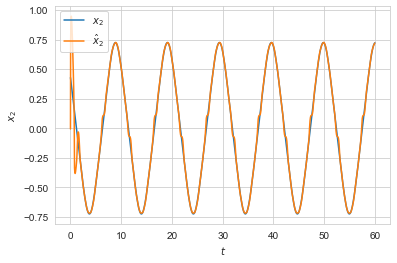

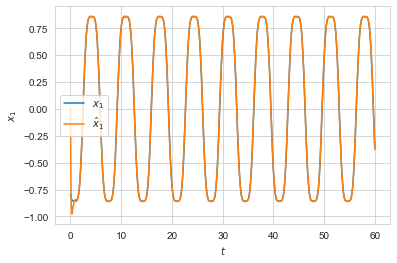

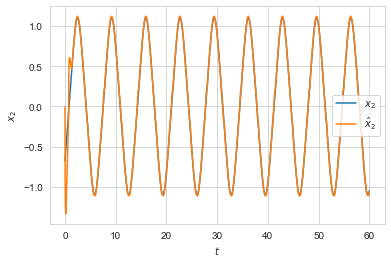

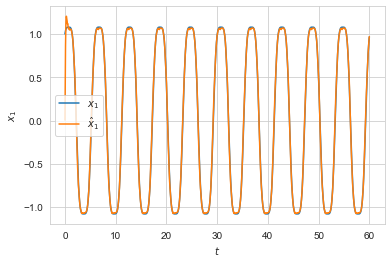

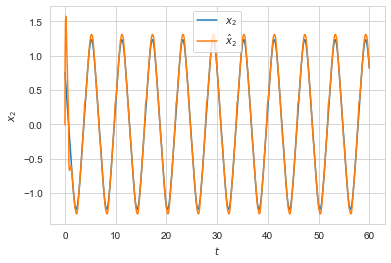

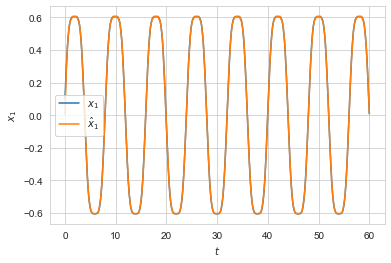

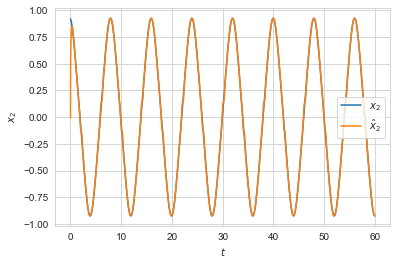

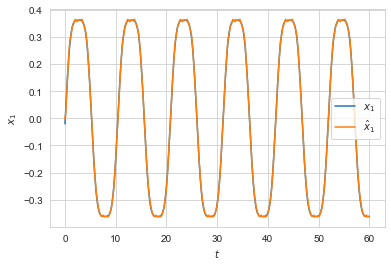

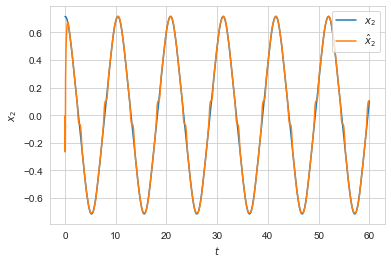

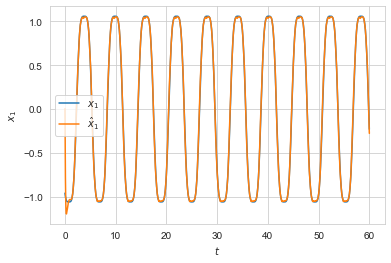

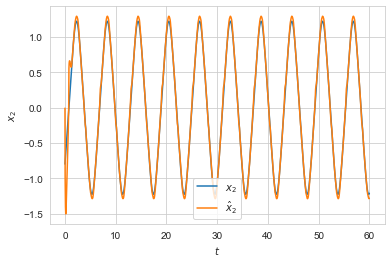

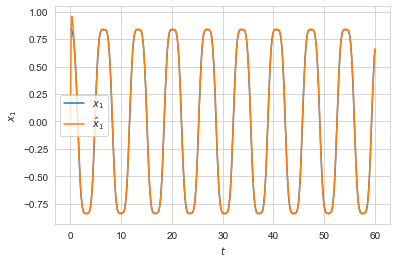

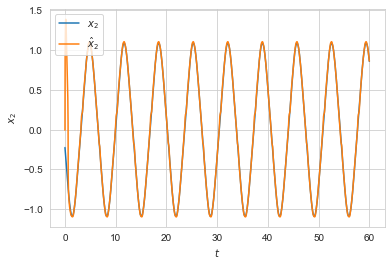

No handles with labels found to put in legend.


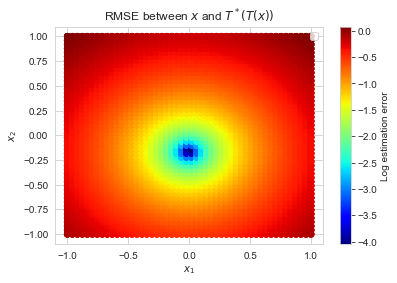

No handles with labels found to put in legend.


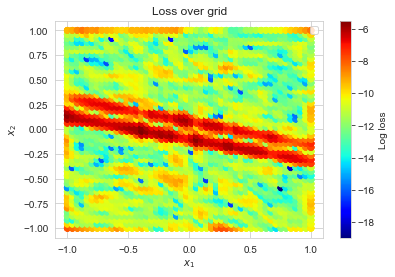

In [22]:
nb_trajs = 10
verbose = True
num_samples = 100
limits = np.array([[-1.,1], [-1.,1]])
tsim=(0, 60)
dt=1e-2

# Heatmap of RMSE(x, x_hat) with T_star
mesh = learner_T_star.model.generate_data_svl(limits, num_samples, method='uniform')
num_samples = len(mesh)  # update num_samples from uniform grid
print(f'Shape of mesh for evaluation: {mesh.shape}')
x_mesh = mesh[:, :learner_T_star.model.dim_x]
z_mesh = mesh[:, learner_T_star.model.dim_x:]
x_hat_star = learner_T_star.model('T_star', z_mesh)
error = RMSE(x_mesh, x_hat_star, dim=1)
for i in range(1, x_mesh.shape[1]):
    # https://stackoverflow.com/questions/37822925/how-to-smooth-by-interpolation-when-using-pcolormesh
    name = 'RMSE_heatmap' + str(i) + '.pdf'
    plt.scatter(x_mesh[:, i - 1], x_mesh[:, i], cmap='jet',
                c=np.log(error.detach().numpy()))
    cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    cbar.set_label('Log estimation error')
    plt.title(r'RMSE between $x$ and $\hat{x}$')
    plt.xlabel(rf'$x_{i}$')
    plt.ylabel(rf'$x_{i + 1}$')
    plt.legend()
    # plt.savefig(os.path.join(learner_T_star.results_folder, name),
    #             bbox_inches='tight')
    if verbose:
        plt.show()
    plt.close('all')

# Estimation over the test trajectories with T_star
random_idx = np.random.choice(np.arange(num_samples),
                              size=(nb_trajs,))
trajs_init = x_mesh[random_idx]
traj_folder = os.path.join(learner_T_star.results_folder, 'Test_trajectories')
tq, simulation = learner_T_star.system.simulate(trajs_init, tsim, dt)
measurement = learner_T_star.model.h(simulation)
# Save these test trajectories
os.makedirs(traj_folder, exist_ok=True)
traj_error = 0.
for i in range(nb_trajs):
    # TODO run predictions in parallel for all test trajectories!!!
    # Need to figure out how to interpolate y in parallel for all
    # trajectories!!!
    y = torch.cat((tq.unsqueeze(1), measurement[:, i]), dim=1)
    estimation = learner_T_star.model.predict(y, tsim, dt).detach()
    traj_error += RMSE(simulation[:, i], estimation)

    # current_traj_folder = os.path.join(traj_folder, f'Traj_{i}')
    # os.makedirs(current_traj_folder, exist_ok=True)
    # filename = f'True_traj_{i}.csv'
    # file = pd.DataFrame(simulation[:, i].cpu().numpy())
    # file.to_csv(os.path.join(current_traj_folder, filename),
    #             header=False)
    # filename = f'Estimated_traj_{i}.csv'
    # file = pd.DataFrame(estimation.cpu().numpy())
    # file.to_csv(os.path.join(current_traj_folder, filename),
    #             header=False)
    for j in range(estimation.shape[1]):
        name = 'Traj' + str(j) + '.pdf'
        plt.plot(tq, simulation[:, i, j].detach().numpy(),
                 label=rf'$x_{j + 1}$')
        plt.plot(tq, estimation[:, j].detach().numpy(),
                 label=rf'$\hat{{x}}_{j + 1}$')
        plt.legend()
        plt.xlabel(rf'$t$')
        plt.ylabel(rf'$x_{j + 1}$')
        # plt.savefig(os.path.join(current_traj_folder, name),
        #             bbox_inches='tight')
        if verbose:
            plt.show()
        plt.close('all')
# filename = 'RMSE_traj.txt'
# with open(os.path.join(traj_folder, filename), 'w') as f:
#     print(traj_error, file=f)

# Invertibility heatmap
z_hat_T, x_hat_AE = learner_T_star.model('Autoencoder', x_mesh)
error = RMSE(x_mesh, x_hat_AE, dim=1)
for i in range(1, x_mesh.shape[1]):
    name = 'Invertibility_heatmap' + str(i) + '.pdf'
    plt.scatter(x_mesh[:, i - 1], x_mesh[:, i], cmap='jet',
                c=np.log(error.detach().numpy()))
    cbar = plt.colorbar()
    cbar.set_label('Log estimation error')
    plt.title(r'RMSE between $x$ and $T^*(T(x))$')
    plt.xlabel(rf'$x_{i}$')
    plt.ylabel(rf'$x_{i + 1}$')
    plt.legend()
    # plt.savefig(os.path.join(learner_T_star.results_folder, name),
    #             bbox_inches='tight')
    if verbose:
        plt.show()
    plt.close('all')

# Loss heatmap
losses = []
if learner_T_star.method == "Autoencoder":
    # random_idx = np.random.choice(np.arange(num_samples),
    #                               size=(5000,))
    random_idx = np.arange(num_samples)
    loss, loss1, loss2 = learner_T_star.model.loss_autoencoder(
        x_mesh[random_idx], x_hat_AE[random_idx],
        z_hat_T[random_idx], dim=-1)
    losses.append(loss1)
    losses.append(loss2)
elif learner_T_star.method == "T_star":
    random_idx = np.arange(num_samples)
    loss = learner_T_star.model.loss_T_star(x_mesh[random_idx],
                                  x_hat_star[random_idx], dim=-1)
    losses.append(loss)
for j in range(len(losses)):
    loss = losses[j]
    for i in range(1, x_mesh.shape[1]):
        name = f'Loss{j + 1}_{i - 1}.pdf'
        plt.scatter(x_mesh[random_idx, i - 1],
                    x_mesh[random_idx, i], cmap='jet',
                    c=np.log(loss.detach().numpy()))
        cbar = plt.colorbar()
        cbar.set_label('Log loss')
        plt.title('Loss over grid')
        plt.xlabel(rf'$x_{i}$')
        plt.ylabel(rf'$x_{i + 1}$')
        plt.legend()
        # plt.savefig(os.path.join(learner_T_star.results_folder, name),
        #             bbox_inches='tight')
        if verbose:
            plt.show()
        plt.close('all')